### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
# !pip install numdifftools

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd
from scipy.optimize import minimize
from scipy.stats import norm
%config InlineBackend.figure_format='retina'

In [21]:
data = np.load('./hw_data/hw3_data_1.npy')

# Analytical Method

For a Heteroscedastic Gaussian: 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

In [22]:
x_i = data[:, 0]
err_i = data[:, 1]
mu_an = (np.sum(x_i/err_i**2))/(np.sum(1/err_i**2)) # Analytical mu
sigma_mu_an = 1/np.sqrt(np.sum(1/err_i**2))         # Analytical Error on mu
print("Analytical Result: Mean = ",np.round(mu_an,3),", Error on mean =",np.round(sigma_mu_an,3))

Analytical Result: Mean =  3.918 , Error on mean = 0.095


# Numerical Method

For a Heteroscedastic Gaussian: 
$$L = \prod_{i=1}^N \left( \frac{1}{\sigma_i\sqrt{2\pi}} \right) \exp\left( -\frac{1}{2} \sum \left[\frac{-(x_i-\mu)}{\sigma_i} \right]^2 \right).$$

$$ \Rightarrow {\rm lnL} =  \sum_{i=1}^N  -\frac{1}{2}{\rm ln}(2\pi \sigma_{i}^2) - \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

$$ \Rightarrow {\rm lnL} =  {\rm constant} - \sum_{i=1}^N \left( {\rm ln}\sigma_{i} + \frac{(x_i - \mu)^2}{2\sigma_i^2} \right).$$

As we are minimizing over $\mu$, the term ${\rm ln}\sigma_{i}$ can be ignored but is written to show the complete relation.

In [33]:
# defining the function for minimize
def nlnL(mu0,x_i,err_i):
    return 0.5*np.log(2*np.pi) + np.sum(np.log(err_i) + (x_i-mu0)**2/(2*err_i**2))
    # used the negative likelihood for minimization procedure
   
best_fit = minimize(nlnL,np.mean(x_i), args=(x_i, err_i)) # took simple np.mean(x) as the starting point

mu_num = best_fit.x[0]
print("Best Fit Mean:", np.round(mu_num,3))

Best Fit Mean: 3.918


Here I have tried to estimate the Fisher uncertainity of the mean using the method given in `Lecture_5`.
The method takes product of gaussian distribution of all likelihoods with some mean and sigma. 
However, for a Heteroscedastic data, each gaussian distribution will have its own sigma. 

The problem arises because the sample/sigma value is very close to 1 and thus the likelihood values are really small, as seen in next figure.
Thus, when computing the product of likelihoods, the value comes out to be really small and as a result the Fisher uncertainity was not obtained. 

In the next cell, I have given the code which does not produce the result by simply taking the product of gaussians. 

Sample, 1.988242934890275 , Sigma 1.4026269167539764 , Ratio 1.417513745915812


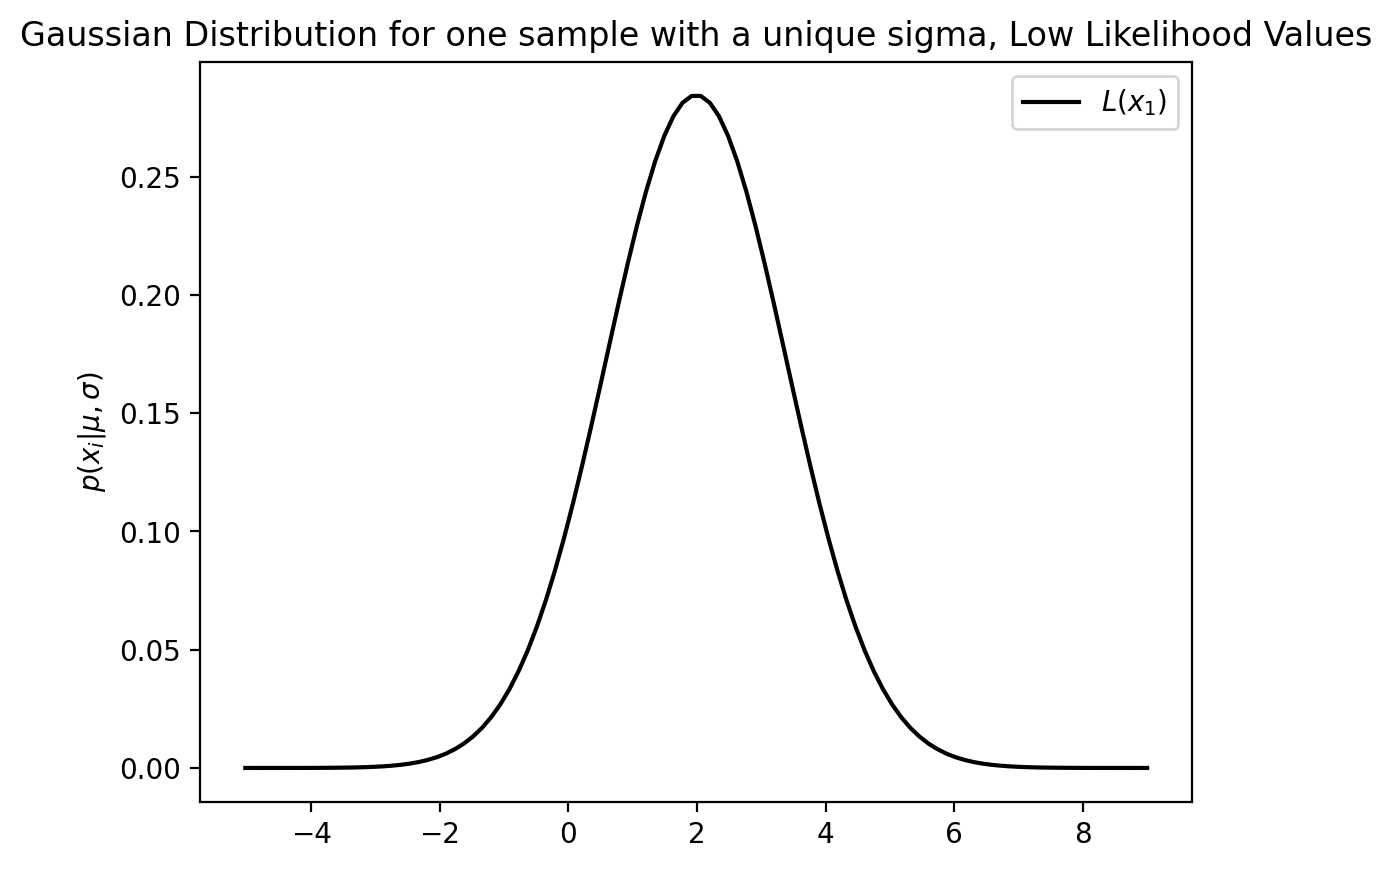

In [6]:
sample = x_i[1]
sigma = err_i[1]
print("Sample,",sample,", Sigma",sigma,", Ratio",sample/sigma)

xgrid = np.linspace(sample - 5*sigma,sample + 5*sigma,100) # Creating a grid for x values +- 5 sigma from mean value

L1 = norm.pdf(xgrid,loc=sample,scale=sigma)
plt.plot(xgrid, L1, ls='-', c='black', label=r'$L(x_1)$')
plt.ylabel(rf'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('Gaussian Distribution for one sample with a unique sigma, Low Likelihood Values')
plt.legend()
plt.show()

In [7]:
# Creating a function to get product of all likelihoods
def L_hetro(x_i,err_i,pm=5): 
    # xgrid = np.linspace(x_i - pm*err_i,x_i + pm*err_i) # Creating a grid for x values +- 5 sigma from mean value
    L_i = norm.pdf(xgrid,loc=x_i,scale=err_i) # Each data point is a gaussian with a different sigma (Heteroscedastic)
    return L_i
L = 1
for i in range(len(x_i)):
    L_i = L_hetro(x_i[i],err_i[i])
    L = L*L_i

print(L)
sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 4.94065646e-324 5.97783610e-302 5.54796711e-281 5.51980287e-261
 5.88725809e-242 6.73135351e-224 8.25071411e-207 1.08412784e-190
 1.52710630e-175 2.30599233e-161 3.73289922e-148 6.47790370e-136
 1.20509845e-124 2.40331326e-114 5.13804679e-105 1.17756677e-096
 2.89316264e-089 7.62008771e-083 2.15152753e-077 6.51228897e-073
 2.11310090e-069 7.350326

/var/folders/jr/6thm8wn52bv9_gbqq6c_j_ph0000gn/T/ipykernel_10164/593581150.py:12: RuntimeWarning: divide by zero encountered in log
  sigma_mu = np.diff(np.log(L), n=2)
/Users/tejassewak/miniconda3/envs/astr3300/lib/python3.12/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


# Bootstrap Method

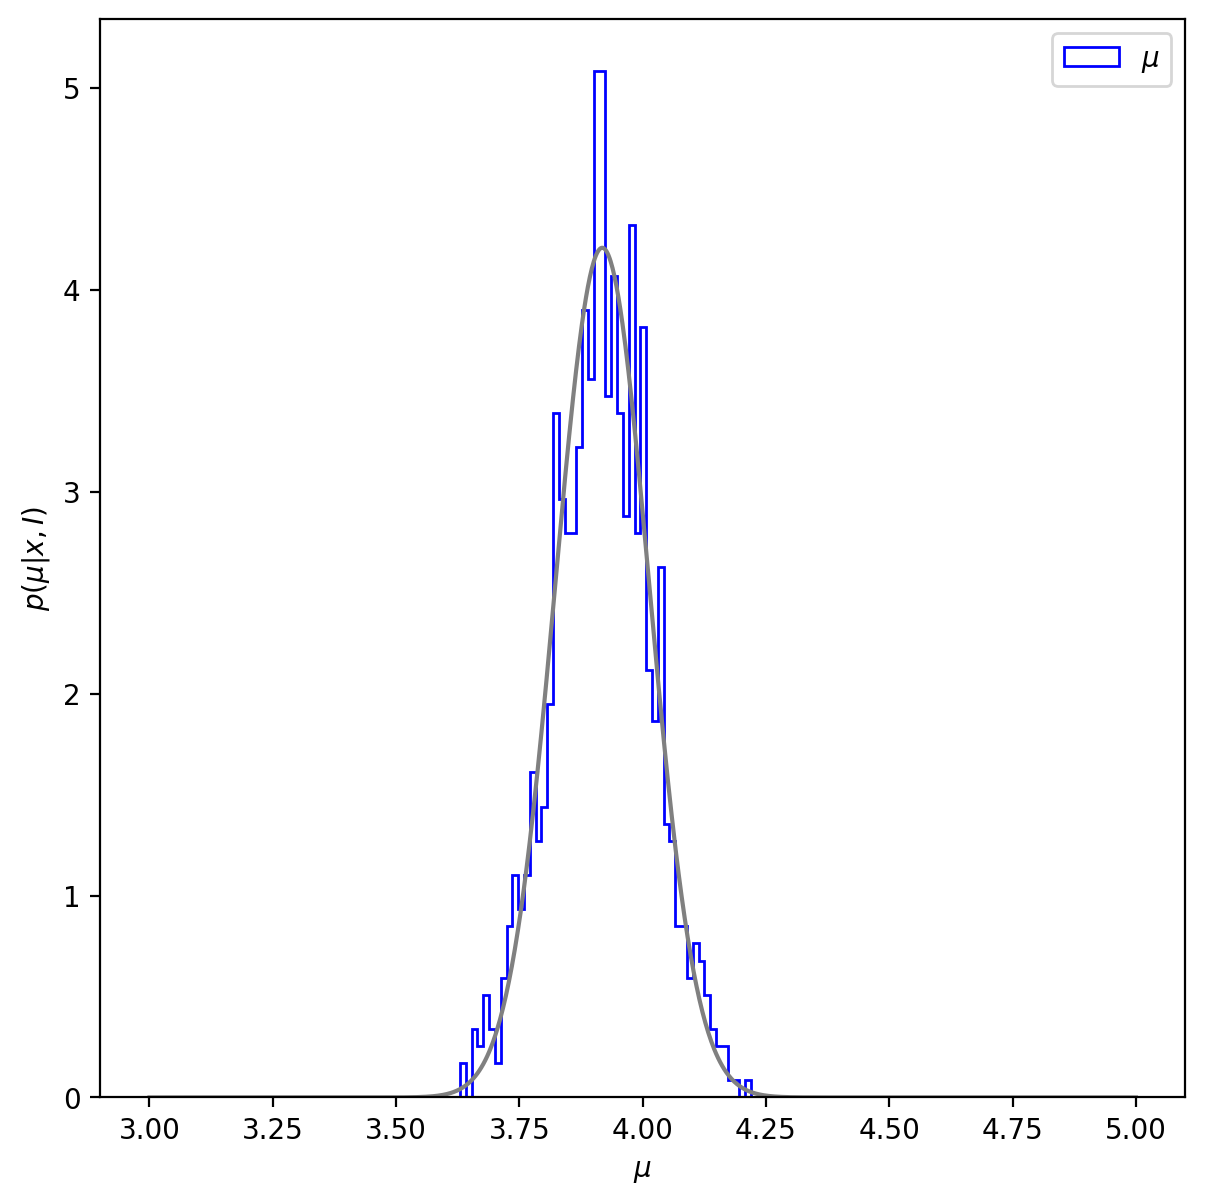

In [41]:
iterations = 1000
mu_num_bs = []

x_bs = []
err_bs = []
for i in range(iterations):
    choices = np.random.choice(len(x_i),len(x_i),replace=True) # Number of choices is the length of data and also place back number once taken
    x_i_new = x_i[choices]
    x_bs.append(x_i_new)
    err_i_new = err_i[choices]
    err_bs.append(err_i_new)
    # Find best-fit mean
    best_fit = minimize(nlnL,np.mean(x_i_new), args=(x_i_new, err_i_new))
    mu_num_bs.append(best_fit.x[0])

# Plot distribution of sample mean from bootstrap method # Took from lecture 6 notes

fig, ax = plt.subplots(figsize=(7, 7))

ax.hist(mu_num_bs, bins=50, density=True, 
        histtype='step', color='blue', ls='dashed', 
        label=r'$\mu$')
xgrid = np.linspace(3,5,1000)
pdf = norm.pdf(xgrid,loc=mu_an,scale=sigma_mu_an)
ax.plot(xgrid, pdf, color='gray')

# ax.hist(mu2_bootstrap, bins=50, density=True, 
#         histtype='step', color='red', 
#         label=r'$\sigma_G\ {\rm (quartile)}$')
# ax.plot(xgrid, pdf2, color='gray')

# ax.set_xlim(0.82, 1.18)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$p(\mu|x,I)$')
ax.legend()

plt.show()

# Laplace Dist

For a Laplace distribution:
$$L = \prod_{i=1}^{n} \frac{1}{2\Delta} \exp\left( -\frac{|x_i - \mu|}{\Delta} \right)$$

$$\Rightarrow \ln L = \sum_{i=1}^{n} \left(-\ln(2\Delta) - \frac{1}{\Delta} |x_i - \mu|\right)$$

In [52]:
# Define negative likelihood for Laplace function
def nlnL_L(par,x_i):
    mu, delta = par
    return np.sum(np.log(2*delta)+np.abs(x_i-mu)/delta)

best_fit_L = minimize(nlnL_L,[np.mean(x_i), np.mean(err_i)], args=(x_i)) 
mu_L, delta_L = best_fit_L.x[0],best_fit_L.x[1]
print("Mu_L =", mu_L,", Delta_L = ",delta_L)

Mu_L = 4.088079626833067 , Delta_L =  0.8822692449009738


# AIC

In [53]:
#no. of free params
k1 = 1 #Gaussian
k2 = 2 #Laplace
N = len(x_i)
# defining again for clarity:

lnL_Gauss = -N*0.5*np.log(2*np.pi) - np.sum(np.log(err_i) + (x_i-mu_num)**2/(2*err_i**2))

lnL_Laplace = np.sum(np.log(2*delta_L)+np.abs(x_i-mu_L)/delta)

aic1 = -2*lnL_Gauss +  2*k1 + 2*k1*(k1+1)/(N-k1-1)
aic2 = -2*lnL_Laplace +  2*k2 + 2*k2*(k2+1)/(N-k2-1)

# aic1 = -2*(-nlnL(mu_num,x_i,err_i)) +  2*k1 + 2*k1*(k1+1)/(N-k1-1)
# aic2 = -2*(-nlnL_L([mu_L,delta_L],x_i)) +  2*k2 + 2*k2*(k2+1)/(N-k2-1)

print(aic1,aic2)
print("Since aic2<aic1 by very big margin, the Laplace model is strongly favoured.")

296.5565421011481 -309.45412101297404
Since aic2<aic1 by very big margin, the Laplace model is strongly favoured.


# Bootstrap Error on Mean and Delta for Laplace

In [79]:
# corner.corner?

In [71]:
# Define negative likelihood for Laplace function again
def nlnL_L(par,x_i):
    mu, delta = par
    delta = np.abs(delta) # Just to ensure that delta does not go negative and cause error in log value
    return np.sum(np.log(2*delta)+np.abs(x_i-mu)/delta)

mu_L_vals = []
delta_L_vals = []
for i in range(1000):
    best_fit_L = minimize(nlnL_L,[np.mean(x_bs[i]), np.std(x_bs[i])], args=(x_bs[i])) 
    mu_L, delta_L = best_fit_L.x[0],best_fit_L.x[1]
    mu_L_vals.append(mu_L)
    delta_L_vals.append(delta_L)

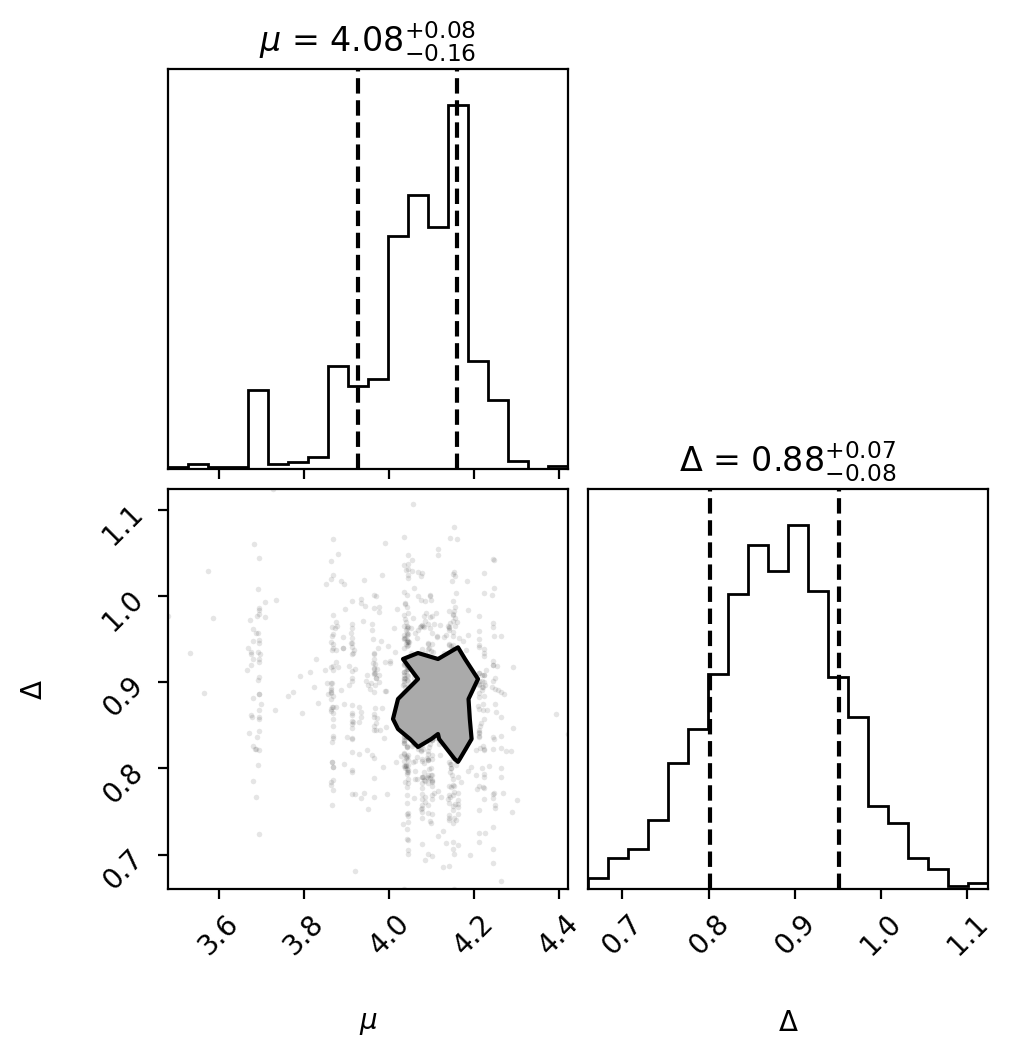

In [113]:
corner_data = np.zeros((1000,2))
corner_data[:,0] = mu_L_vals
corner_data[:,1] = delta_L_vals
figure = corner.corner(corner_data,levels=(0.32,0.05),quantiles=[0.16, 0.84],labels=[rf"$\mu$", rf"$\Delta$"],
                   plot_datapoints=True,fill_contours=True,show_titles=True,title_kwargs={"fontsize": 12},title_quantiles=[0.16, 0.5, 0.84])

plt.show()

# Fisher Uncertainity

In [115]:
import numdifftools as nd
# f_lnlaplace = -nlnL_L(par,x_i)

H = nd.Hessian(lambda par: nlnL_L(par, x_i))([mu_L, delta_L])
sigma_laplace = np.linalg.inv(H)**0.5
print("Error on mean = ",np.round(sigma_laplace[0,0],4), ", Error on Delta = ",np.round(sigma_laplace[1,1],4),": Laplace")

# Get 1sigma uncertainity from the corner plot
mu_q86,mu_q16 = 0.08,-0.16
sigma_mu_bs = (mu_q86-mu_q16)/2

d_q86,d_q16 = 0.07,-0.08
sigma_d_bs = (d_q86-d_q16)/2

print("Error on mean = ",np.round(sigma_mu_bs,4), "Error on Delta = ",np.round(sigma_d_bs,4), ": Bootstrap")
print("Bootstrap error on mean is bigger")

Error on mean =  0.0598 , Error on Delta =  0.1007 : Laplace
Error on mean =  0.12 Error on Delta =  0.075 : Bootstrap
Bootstrap error on mean is bigger
